# EEE6504 - HW3 #
## Jackson Cornell ##

In [1]:
import math
import time
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

### Functions ###

In [2]:
# LMS filter
def LMS(x, d, mu, K) :
    # calculate epochs
    epochs = np.size(x) - K
    # initialize vectors
    w = np.zeros(K)
    y = np.zeros(epochs)
    J = np.zeros(epochs)
    w_traces = np.zeros([epochs,K])
    # steepest descent
    for index in range(epochs) :
        # define window
        x_t = x[index:index+K]
        d_t = d[index+K-1]
        # stochastic gradient descent
        e = d_t - w.T@x_t
        w = w + mu*e*x_t
        y[index] = w.T@x_t
        # update J for learning curve
        J[index] = e**2
        # update weight traces
        w_traces[index,:] = w
    # return weights and learning curve
    return w, J, w_traces, y

In [3]:
# KLMS filter
def KLMS(x, d, kernel_size, M, mu) :
    # calculate epochs
    epochs = np.size(x) - M
    # initialize vectors
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    a = np.zeros(epochs)
    growth = np.zeros(epochs)
    # steepest descent
    for iter in  range(1) :
        for i in range(epochs) :
            # compute output
            y[i] = 0
            x1 = x[i:(i+M)]
            for j in range(i) :
                x2 = x[j:(j+M)]
                y[i] += a[j] * Kernel(x1, x2, kernel_size)
            # update error and coefficients
            e[i] = d[i+M-1] - y[i]
            a[i] = mu*e[i]
            growth[i] = i+1
    # return weights and learning curve
    return e**2, y, growth

In [4]:
# QKLMS filter
def QKLMS(x, d, mu, kernel_size, M, eps) :
    # calculate epochs
    epochs = np.size(x) - M
    # initialize vectors
    y = np.zeros(epochs)
    e = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    err = []
    # steepest descent
    for iter in range(1) :
        for i in range(epochs) :
            # compute output
            y[i] = 0
            x1 = x[i:(i+M)]
            for j in range(len(C) - M) :
                x2 = C[j:(j+M)]
                y[i] += mu * err[j] * Kernel(x1, x2, kernel_size)
            # calculate error
            e[i] = d[i+M-1] - y[i]
            # compute distance
            minimum = 1e100
            index = 0
            for j in range(len(C)) :
                dis = abs(x[i] - C[j])
                if (dis < minimum) :
                    minimum = dis
                    index = j
            # update codebook
            if (minimum > eps) :
                C.append(x[i])
                err.append(e[i])
            else :
                err[index] += e[i]
            growth[i] = len(C)
    # return weights and learning curve
    return e**2, y, growth

In [5]:
# Gaussian kernel
def Kernel(x, x1, cov) :
    return math.exp(-np.linalg.norm(x - x1, 2)**2 / cov**2)

## Part A ##
Simulate dynamics of channel and generate channel output of size 5000.

In [6]:
# simulate gaussian input noise
mean = 0
var = 1
L = 5002
y = np.random.normal(mean, var, L)

In [7]:
# simulate linear channel component
h = np.array([-0.8, 0.7])
t = np.convolve(h, y)[0:L]

In [8]:
# simulate memoryless non-linear channel component
q = t + 0.25*(t**2) + 0.11*(t**3)

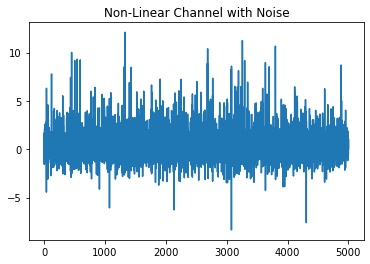

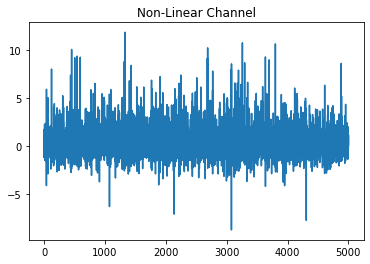

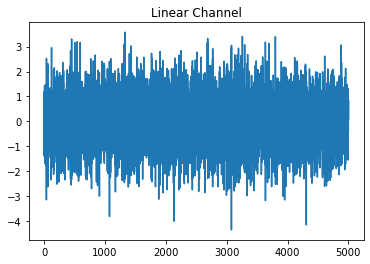

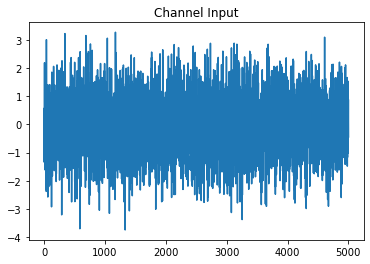

In [9]:
# add gaussian noise to produce filter input
P = np.sum(q**2) / L
SNR = 10**(15/10)
xn = q + np.sqrt(P/SNR) * np.random.normal(0, 1, L)

# plot input
plt.plot(np.linspace(0, L, L), xn)
plt.title("Non-Linear Channel with Noise")
plt.show()

plt.plot(np.linspace(0, L, L), q)
plt.title("Non-Linear Channel")
plt.show()

plt.plot(np.linspace(0, L, L), t)
plt.title("Linear Channel")
plt.show()

plt.plot(np.linspace(0, L, L), y)
plt.title("Channel Input")
plt.show()

## Part B ##
Using channel output and time-lagged channel input, use adaptive filters to estimate the system dynamics.

The LMS was ran as a benchmark for KLMS and QKLMS. Though its weight's converged, its linear operations made it difficult for the LMS's learning curve to converge as well.

The KLMS was initially run using a step size of 0.001 and kernel size of 1. Step sizes of 0.01 and 0.0001 were tested and compared based on the learning curve, to which the step size of 0.01 performed much better. Kernel sizes of 0.5 and 2 were next tested. Through this method, it was experimentally found that kernel sizes greater than 1 performed better than those less than one. The KLMS performed optimally at a kernel size of around 5. The learning curve does overall converge, though there are infrequent spikes of large error.

The QKLMS was initially run with the optimal parameters found for the KLMS (step size of 0.01, kernel size of 5) and a quantization threshold of 1e-6. At this threshold, the QKLMS performs practically the same as the KLMS. The threshold was continuously increased by factors of 10 (1e-5, 1e-4,...) and compared based on both filter growth rate and learning curve convergence. Thresholds too large tend to perform quickly and efficiently, but do not converge in their learning curve. Errors too small perform sub-optimally in terms of performance (even worse than the KLMS in some cases) but have learning curve converges conparable to that of the KLMS. A quantization threshold of 5e-4 was experimentally found to have the best trade-off, with a converging learning curve and logarithmic growth curve.



In [10]:
# construct desired signal
x = xn[2:5002]
d = y[0:5000]

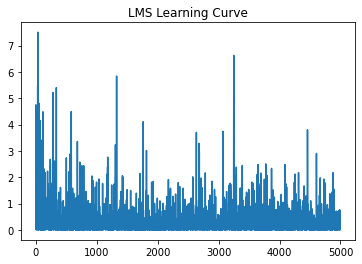

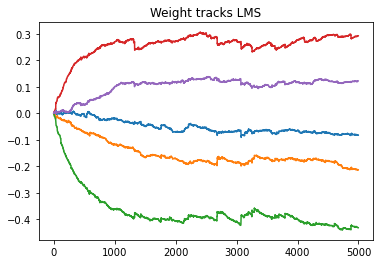

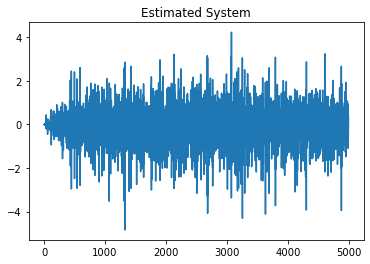

In [11]:
# LMS filter
K = 5
mu = 0.001
start = time.time()
w1, J1, w1_traces, y1 = LMS(x, d, mu, K)
end = time.time()
lms_time = end - start

# plot learning curve
plt.plot(np.linspace(0, np.size(J1), np.size(J1)), J1)
plt.title("LMS Learning Curve")
plt.show()

# plot weights
for i in range(K) :
    plt.plot(np.linspace(0, np.size(x)-K, np.size(x)-K), w1_traces[:,i])
plt.title("Weight tracks LMS")
plt.show()

# plot estimated system vs actual system
plt.plot(np.linspace(0, np.size(y1), np.size(y1)), y1)
plt.title("Estimated System")
plt.show()

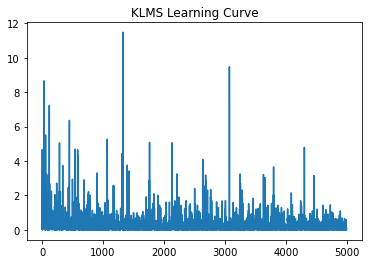

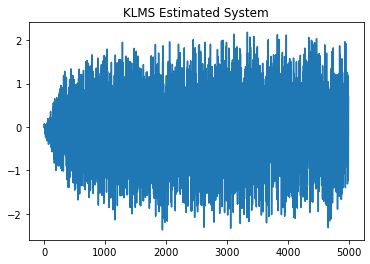

In [12]:
# KLMS filter
mu = 0.01
filter_size = 5
kernel_size = 5
start = time.time()
J2, y2, size2 =  KLMS(x, d, kernel_size, filter_size, mu)
end = time.time()
klms_time = end - start

# plot learning curve
plt.plot(np.linspace(0, np.size(J2), np.size(J2)), J2)
plt.title("KLMS Learning Curve")
plt.show()

# plot estimated system vs actual system
plt.plot(np.linspace(0, np.size(y2), np.size(y2)), y2)
plt.title("KLMS Estimated System")
plt.show()

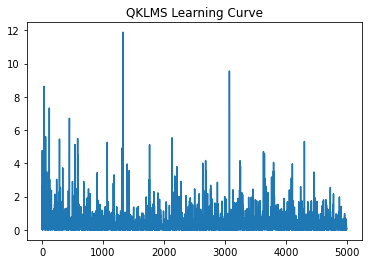

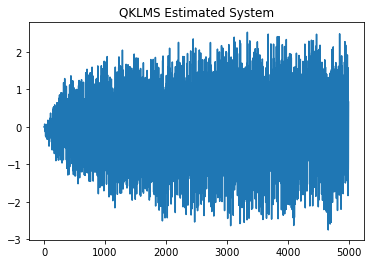

In [13]:
# QKLMS filter
mu = 0.05
filter_size = 5
kernel_size = 5
threshold = 5e-4
start = time.time()
J3, y3, size3 =  QKLMS(x, d, mu, kernel_size, filter_size, threshold)
end = time.time()
qklms_time = end - start

# plot learning curve
plt.plot(np.linspace(0, np.size(J3), np.size(J3)), J3)
plt.title("QKLMS Learning Curve")
plt.show()

# plot estimated system vs actual system
plt.plot(np.linspace(0, np.size(J3), np.size(J3)), y3)
plt.title("QKLMS Estimated System")
plt.show()

## Part C ##
The three filters are compared in terms of their learning curve convergence and overall performance.

In terms of growth curves, the LMS has a constant size of 5, the KLMS grows linearly, and the QKLMS grows roughly logarithmically. The growth curves can be correlated to not only the space it takes to store the filter, but also the runtime of the filters. The filter with the fastest growing curve, the KLMS, had a runtime of 158 seconds. The QKLMS and LMS had runtimes of about 155 and 0.05 seconds, respectively. In terms of computational performance, it is clear that the LMS peforms the best, and the KLMS the worst. It is worth noting that the implementation for the KLMS and QKLMS were not optimal, but the growth curves should nonetheless be telling of an overall comparison of computational performance.

To compare how well the filters simulated the dynamics of the non-linear channel, two measures can be used: their respective learning curves, and their correlation with the channel input. Though the LMS did indeed converge, its linear operations meant the error would always be quite high given the system. The KLMS and QKLMS both have comparable learning curves, with a clear overall convergance and infrequent spikes in error. The correlation measure is the most telling way to see how well the filters approximated the non-linear channel. The desired signal's autocorrelation at lag 0 is used as a benchmark for how well the filters approximated the filter. The QKLMS surprisingly had the highest correlation value of approximately 3700, while the KLMS was around 3400, and LMS was about 3300. One explanation for the QKLMS beating the KLMS is that the KLMS overfitted the data, while the QKLMS's quantization algorithm allowed it to fit the dynamic model better.

Overall, it can be inferred that in terms of trade-off of computational performance and estimation of the non-linear channel, the QKLMS performed the best, as it had a higher correlation value than that of the KLMS and LMS while performing better in terms of computational cost. The speed of the QKLMS can also be increased by increasing the threshold to about 1e-3, which would only slightly dimish its correlation value.

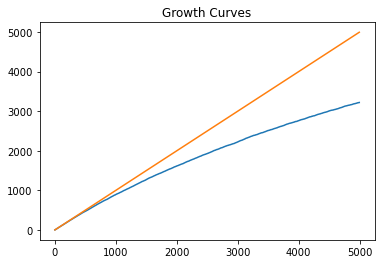

In [14]:
# plot growth curves
plt.plot(np.linspace(0, np.size(size3), np.size(size3)), size3)
plt.plot(np.linspace(0, np.size(size2), np.size(size2)), size2)
plt.title("Growth Curves")
plt.show()

In [15]:
# compare times
print("LMS execution time:", lms_time)
print("KLMS execution time:", klms_time)
print("QKLMS execution time:", qklms_time)

LMS execution time: 0.03846597671508789
KLMS execution time: 157.56441688537598
QKLMS execution time: 155.21360397338867


In [16]:
# compare correlations of signals
print("LMS and channel input correlation:", np.correlate(y1, d)[1])
print("KLMS and channel input correlation:", np.correlate(y2, d)[1])
print("QKLMS and channel input correlation:", np.correlate(y3, d)[1])
print("Input autocorrelation:", np.correlate(d, d)[0])

LMS and channel input correlation: 3266.254170742725
KLMS and channel input correlation: 3354.603509775319
QKLMS and channel input correlation: 3685.7890395349846
Input autocorrelation: 5030.337079871052


# 